In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from textwrap import wrap

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model, get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf


import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [41]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
10,0,266.0,67.20,4.52,61.0,170.0,21.107266,125.0,82.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.590500,5.88000,13.470500,3.0,0.0,5.17,7.0488,12.2188,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,93.0,7.57,83.70,1.831753,5.56,0.348393,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.42,1.31,190.0,NaN,NaN,11.0,4.0,30.0
32,0,170.0,25.27,NaN,61.0,156.0,25.065746,102.0,75.0,0.0,75.0,0.0,90.0,0.833333,0.0,1.0,0.480769,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,21.0,1.0,1.0,3.094000,0.04800,3.142000,0.0,0.0,6.06,6.9000,12.9600,0.0,0.0,0.0,4.68,2.57,1.47,0.45,0.15,0.04,54.9,31.4,9.6,3.2,0.9,4.24,12.4,35.9,2.895161,84.7,29.2,34.5,12.4,0.0,221.0,16.5,12.7,45.8,47.222222,0.057466,150.340136,3.266667,1.748299,0.314103,0.032051,145.0,4.15,9.78,4.48,0.67,1.0,10.0,13.0,1.97,180.0,4.65480,0.0,71.0,1.83606,0.0,99.0,2.560140,0.0,49.0,0.55321,0.0,1.394366,0.690141,0.505103,39.692308,9.40457,4.222849,-0.161062,266.0,74.0,339.0,22.0,30.0,95.0,91.0,6.07,19.35,1.423827,9.92,0.362199,0.0,0.0,2.90,4.70,21.08,8.0,11.0,6.9,5.0,0.724638,350.0,343.0,1.10,0.317003,0.033435,283.909089,56.14,376.0,148.0,90.0,32.9,3.46,19.10,4.

### Handle `prolactin` outliers

In [42]:
mean = df[PROLACTIN].mean()
std = df[PROLACTIN].std()
zscore_3_threshold = mean + (3*std)

<Axes: >

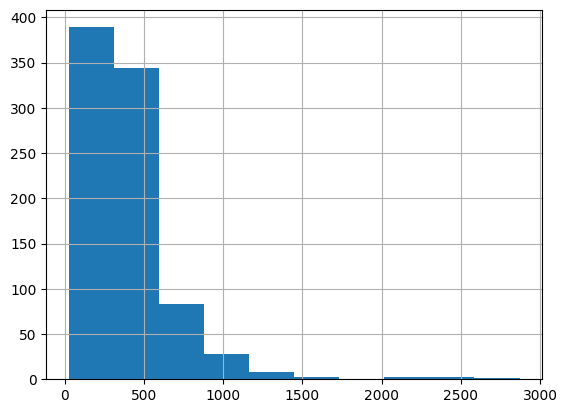

In [43]:
df[PROLACTIN].hist()

In [44]:
df[df[PROLACTIN] > zscore_3_threshold][PROLACTIN]

45     1322.0
85     1376.0
91     1511.0
309    2051.0
379    1301.0
391    2408.0
457    1240.0
489    2573.0
597    1559.0
829    2104.0
885    1422.0
893    1475.0
917    1235.0
925    2870.0
956    1315.0
Name: prolactin, dtype: float64

In [45]:
all_observations = df[PROLACTIN].notna().sum()
outlier_observations = df[df[PROLACTIN] > zscore_3_threshold][PROLACTIN].count()
print(f'Percent of outlier observations: {round((outlier_observations / all_observations)*100, 2)} %')

Percent of outlier observations: 1.74 %


In [46]:
df.loc[df[PROLACTIN] > zscore_3_threshold, PROLACTIN] = np.nan

<Axes: >

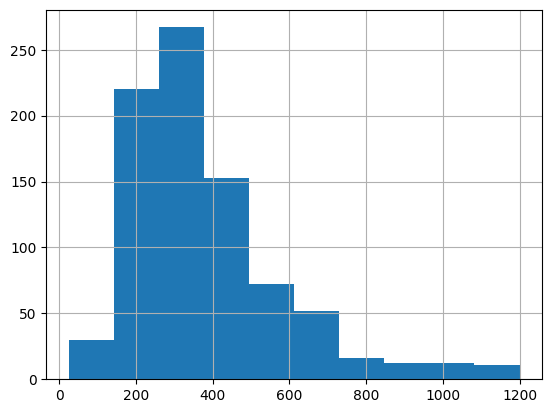

In [47]:
df[PROLACTIN].hist()

In [50]:
df_prolactin_cleaned = df.dropna(subset=[PROLACTIN])

X_prolactin, y_prolactin = df_prolactin_cleaned.drop(columns=[PROLACTIN]), df_prolactin_cleaned[PROLACTIN]
X_train_prolactin, X_test_prolactin, y_train_prolactin, y_test_prolactin = train_test_split(X_prolactin, y_prolactin, test_size=0.2, random_state=42)

### Models exploration

In [49]:
models = [
        DecisionTreeRegressor(max_depth=7, random_state=42),
        Lasso(),
        Ridge(),
        RandomForestRegressor(),
        ]


continuous_preprocessings = {
    'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'PT_KNN': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
    'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
}

categorical_preprocessings = {
    'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    # 'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    # 'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
}


scores_df = explore_all_variations_of_preprocessing(X_train_prolactin, y_train_prolactin, PROLACTIN, models, continuous_preprocessings, categorical_preprocessings)
scores_df

1/48 DecisionTreeRegressor(max_depth=7, random_state=42) PT_iterative_basic original_ohe_no_imputing [-166.19210821 -147.1363017  -189.64786404 -189.93558784 -175.16817069
 -186.39788636 -189.21610798 -163.15820229 -173.54463021 -148.70438725
 -169.73298576 -180.39924585 -157.40780278 -160.89618397 -197.52281334] 173.00401855184498
2/48 Lasso() PT_iterative_basic original_ohe_no_imputing [-139.8110004  -128.88491386 -137.23894418 -155.69356942 -132.11830107
 -148.11452441 -130.87812423 -137.3091251  -135.91014973 -124.14534525
 -120.30001862 -133.01587288 -127.80328357 -137.09684791 -165.13814879] 136.89721129506916
3/48 Ridge() PT_iterative_basic original_ohe_no_imputing [-165.8439677  -144.28813132 -142.65022287 -170.53734048 -138.62638404
 -160.94317113 -148.48557499 -160.00634203 -143.93937444 -156.86701973
 -142.79500229 -141.79871014 -144.46407036 -147.23891495 -181.54234269] 152.66843794390238
4/48 RandomForestRegressor() PT_iterative_basic original_ohe_no_imputing [-131.8316911

,continuous_preprocessing,categorical_pteprocessing,model,MAE
0,PT_iterative_basic,original_ohe_no_imputing,"DecisionTreeRegressor(max_depth=7, random_state=42)",173.004019
1,PT_iterative_basic,original_ohe_no_imputing,Lasso(),136.897211
2,PT_iterative_basic,original_ohe_no_imputing,Ridge(),152.668438
3,PT_iterative_basic,original_ohe_no_imputing,RandomForestRegressor(),138.984863
4,PT_iterative_basic,original_ohe_+_impute_knn,"DecisionTreeRegressor(max_depth=7, random_state=42)",173.547287
5,PT_iterative_basic,original_ohe_+_impute_knn,Lasso(),138.872561
6,PT_iterative_basic,original_ohe_+_impute_knn,Ridge(),150.387971
7,PT_iterative_basic,original_ohe_+_impute_knn,RandomForestRegressor(),140.583226
8,PT_iterative_basic,original_ohe_+_impute_rf,"DecisionTreeRegressor(max_depth=7, random_state=42)",175.534547
9,PT_iterative_basic,original_ohe_+_impute_rf,Lasso(),138.099032


In [56]:
scores_df[scores_df['model']=="Lasso()"].groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    139.125814
                          original_ohe_+_impute_rf     137.307175
                          original_ohe_no_imputing     137.157919
PT_iterative_basic        original_ohe_+_impute_knn    138.872561
                          original_ohe_+_impute_rf     138.099032
                          original_ohe_no_imputing     136.897211
RS_KNN                    original_ohe_+_impute_knn    145.082688
                          original_ohe_+_impute_rf     143.709231
                          original_ohe_no_imputing     142.118578
RS_iterative_basic        original_ohe_+_impute_knn    146.810933
                          original_ohe_+_impute_rf     144.791703
                          original_ohe_no_imputing     144.177588
Name: MAE, dtype: float64

In [57]:
scores_df[scores_df['model']=="RandomForestRegressor()"].groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    141.451367
                          original_ohe_+_impute_rf     141.317026
                          original_ohe_no_imputing     138.876687
PT_iterative_basic        original_ohe_+_impute_knn    140.583226
                          original_ohe_+_impute_rf     141.660030
                          original_ohe_no_imputing     138.984863
RS_KNN                    original_ohe_+_impute_knn    142.397093
                          original_ohe_+_impute_rf     141.490946
                          original_ohe_no_imputing     141.032960
RS_iterative_basic        original_ohe_+_impute_knn    140.773417
                          original_ohe_+_impute_rf     139.704389
                          original_ohe_no_imputing     139.427789
Name: MAE, dtype: float64

In [58]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    152.576680
                          original_ohe_+_impute_rf     150.515483
                          original_ohe_no_imputing     150.303209
PT_iterative_basic        original_ohe_+_impute_knn    150.847761
                          original_ohe_+_impute_rf     150.677804
                          original_ohe_no_imputing     150.388633
RS_KNN                    original_ohe_+_impute_knn    157.857824
                          original_ohe_+_impute_rf     157.870328
                          original_ohe_no_imputing     158.220550
RS_iterative_basic        original_ohe_+_impute_knn    156.013863
                          original_ohe_+_impute_rf     154.918352
                          original_ohe_no_imputing     155.214571
Name: MAE, dtype: float64

Best combo: 

In [84]:
continuous_preprocessor = Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))])

categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

### Lasso

Fitting 15 folds for each of 11 candidates, totalling 165 fits


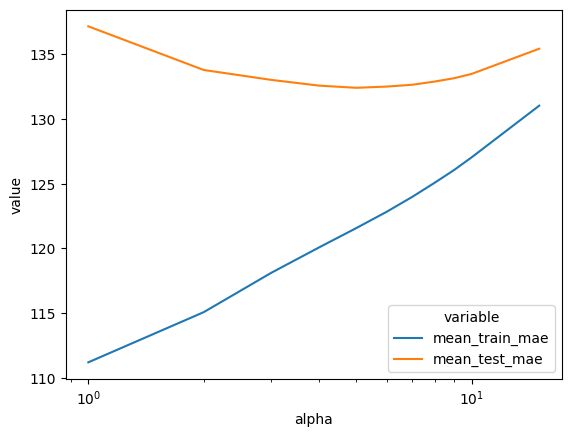

,alpha,mean_train_mae,mean_test_mae
0,1,111.193689,137.157919
1,2,115.070814,133.784092
2,3,118.110251,133.019551
3,4,120.076980,132.574828
4,5,121.567414,132.407890
5,6,122.826883,132.501767
6,7,123.983356,132.642745
7,8,125.065587,132.889281
8,9,126.057523,133.148545
9,10,127.038454,133.482673


In [65]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15],
    }

prolactin_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_prolactin, y_train_prolactin, PROLACTIN, Lasso(), continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
prolactin_lasso_model_hyperparam_tuning_df

### Ridge

Fitting 15 folds for each of 12 candidates, totalling 180 fits


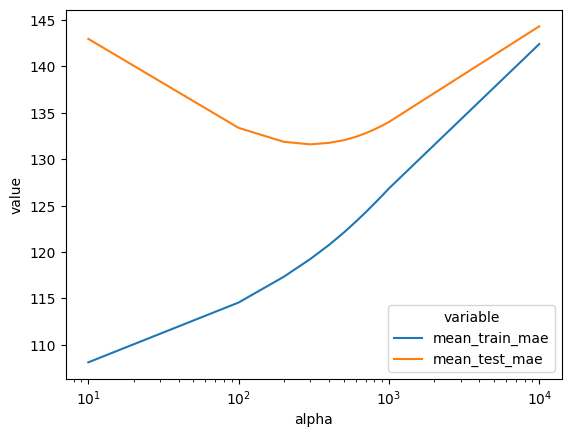

,alpha,mean_train_mae,mean_test_mae
0,10,108.104635,142.972337
1,100,114.551525,133.376907
2,200,117.332797,131.875968
3,300,119.242352,131.602389
4,400,120.768317,131.766379
5,500,122.079614,132.045416
6,600,123.243378,132.404352
7,700,124.277973,132.805269
8,800,125.215253,133.209936
9,900,126.064659,133.615249


In [74]:
ridge_param_grid = {
    "model__alpha": [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 10000],
    }

prolactin_ridge_model_hyperparam_tuning_df =  hyperparameter_tuning_linear(X_train_prolactin, y_train_prolactin, PROLACTIN, Ridge(), continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
prolactin_ridge_model_hyperparam_tuning_df

### Decision Tree Regressor

In [89]:
tree_param_grid = {
    "model__criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
    "model__max_depth": [7, 10, 15, 20, 25, 30],
    "model__splitter": ["random"],
    "model__min_samples_split": [15, 30],
    "model__min_samples_leaf": [10, 20],
    }

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_prolactin, y_train_prolactin, PROLACTIN, DecisionTreeRegressor(), continuous_preprocessor, categorical_preprocessor, tree_param_grid)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 96 candidates, totalling 1440 fits


,params,mean_train_mae,mean_test_mae
46,"{'model__criterion': 'absolute_error', 'model__max_depth': 30, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",118.772749,141.538580
34,"{'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",119.152383,142.766080
42,"{'model__criterion': 'absolute_error', 'model__max_depth': 25, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",118.813298,142.829139
39,"{'model__criterion': 'absolute_error', 'model__max_depth': 20, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",119.585455,143.131630
27,"{'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",119.421653,143.444539
30,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",119.309915,143.462271
38,"{'model__criterion': 'absolute_error', 'model__max_depth': 20, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",118.887667,143.549399
31,"{'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",118.850801,143.821541
26,"{'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",119.965071,144.142315
43,"{'model__criterion': 'absolute_error', 'model__max_depth': 25, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",117.832758,144.845837


In [94]:
model = DecisionTreeRegressor(criterion="absolute_error", max_depth=15, min_samples_leaf=20, min_samples_split=15, splitter='random')

tuned_df = compare_random_states(X_train_prolactin, y_train_prolactin, model, PROLACTIN, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [02:44<00:00,  1.66s/it]


,cv_mae
54,-140.622438
82,-141.152404
65,-141.267754
81,-141.330392
86,-141.360345


In [90]:
param_grid_rf = {
    'model__criterion': ['absolute_error'],
    'model__n_estimators': [100, 200],
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': [None],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [3, 5, 10, 15],
}

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_prolactin, y_train_prolactin, PROLACTIN, RandomForestRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 48 candidates, totalling 720 fits


,params,mean_train_mae,mean_test_mae
17,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__n_estimators': 200}",106.691362,132.739884
19,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 5, 'model__n_estimators': 200}",113.490329,132.744639
16,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__n_estimators': 100}",106.751302,132.836743
23,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 15, 'model__n_estimators': 200}",113.482256,133.018744
12,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}",106.822118,133.028398
21,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 10, 'model__n_estimators': 200}",113.439099,133.061736
22,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 15, 'model__n_estimators': 100}",113.367610,133.079064
13,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}",106.640264,133.082615
20,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 10, 'model__n_estimators': 100}",113.444833,133.083857
18,"{'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 5, 'model__n_estimators': 100}",113.690313,133.215110


In [95]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, max_features='sqrt', min_samples_leaf=10, min_samples_split=15, criterion='absolute_error')

tuned_df = compare_random_states(X_train_prolactin, y_train_prolactin, rf_model, PROLACTIN, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:47<00:00,  5.93s/it]


,cv_mae
77,-131.976783
13,-131.980574
51,-132.062907
76,-132.249041
27,-132.250816


## Best models for prolactin

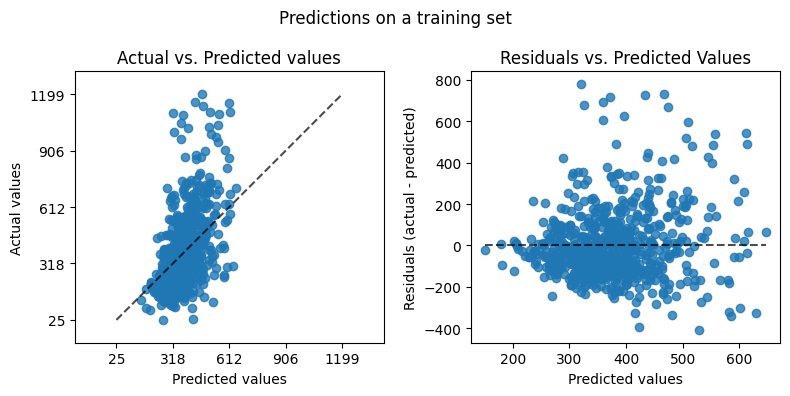

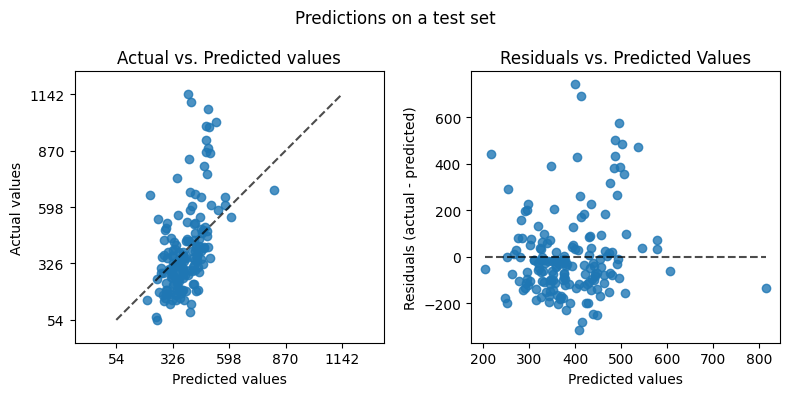

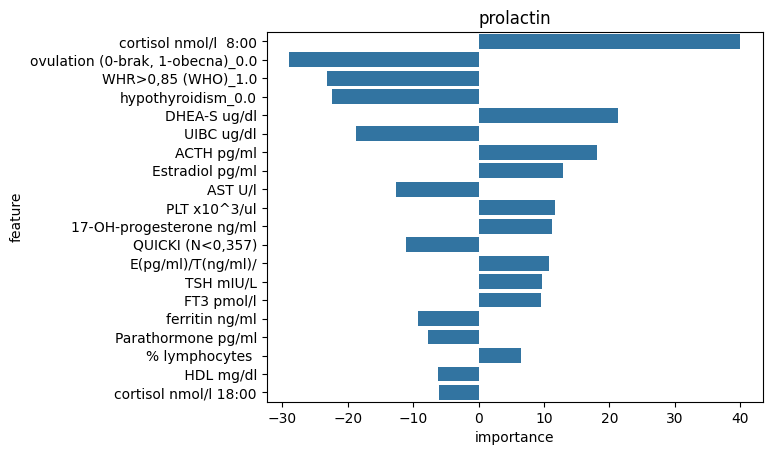

,model,data_set,mse,mae,rmse,r2
0,Lasso(alpha=5),training,29115.506,124.297,170.633,0.259
1,Lasso(alpha=5),test,32741.604,127.532,180.946,0.251


In [82]:
lasso_model = Lasso(alpha=5)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

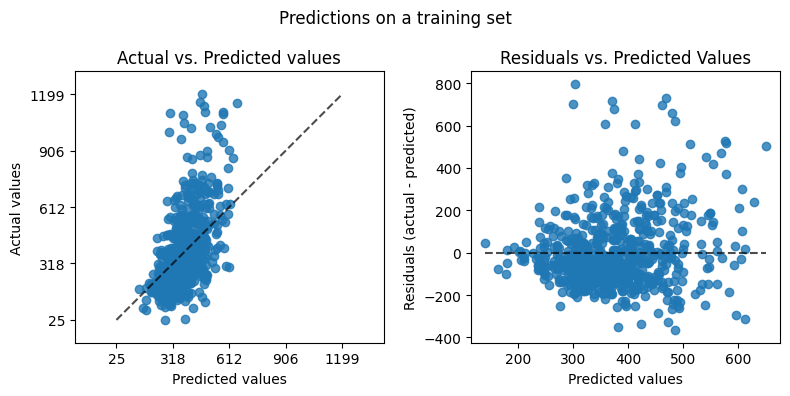

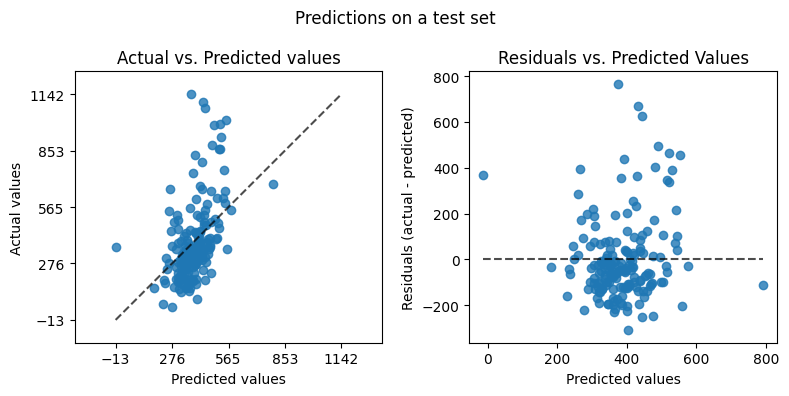

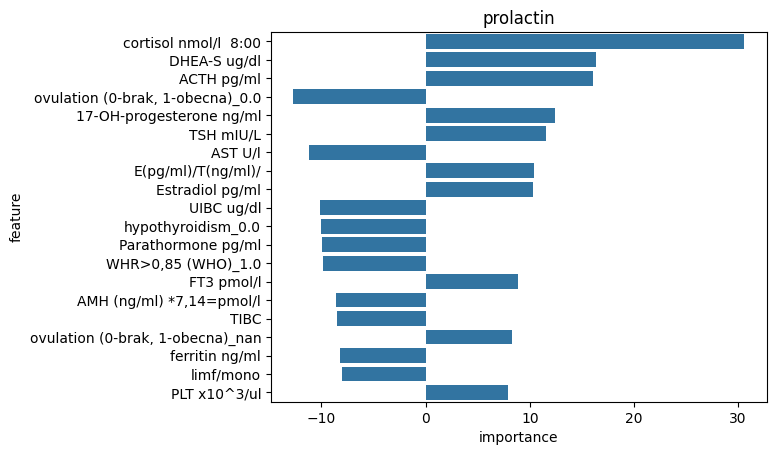

,model,data_set,mse,mae,rmse,r2
0,Ridge(alpha=300),training,27823.886,121.652,166.805,0.292
1,Ridge(alpha=300),test,33324.091,130.798,182.549,0.237


In [83]:
ridge_model = Ridge(alpha=300)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

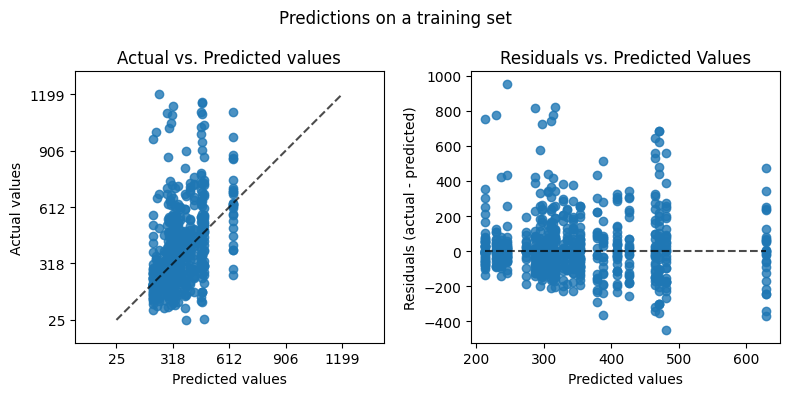

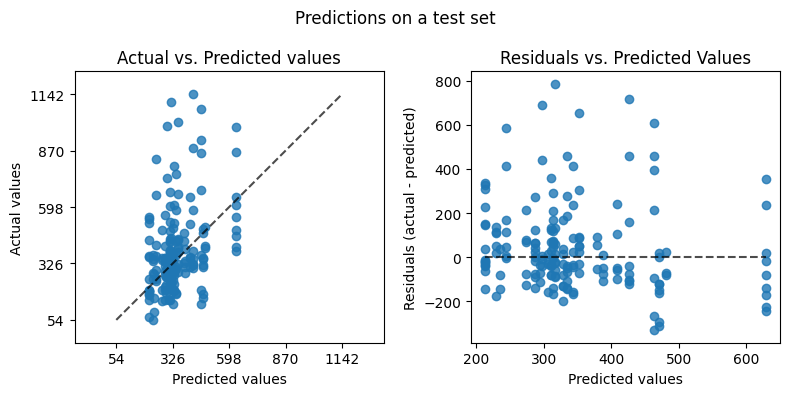

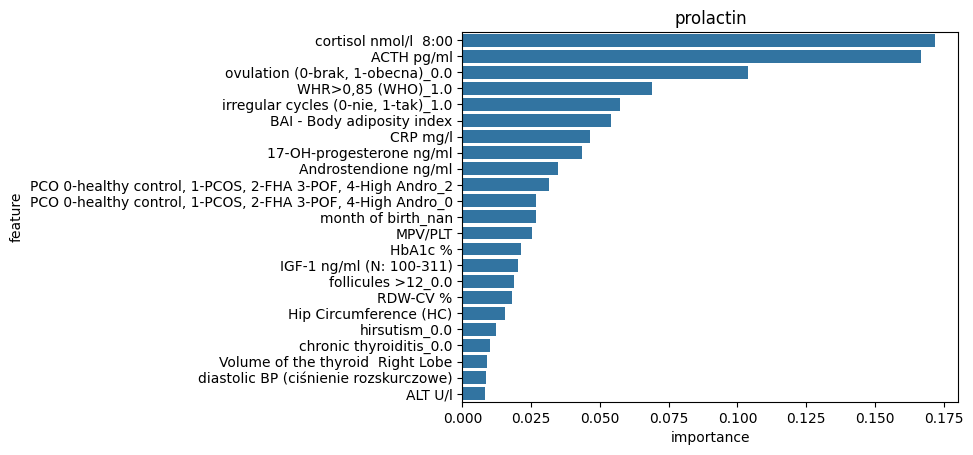

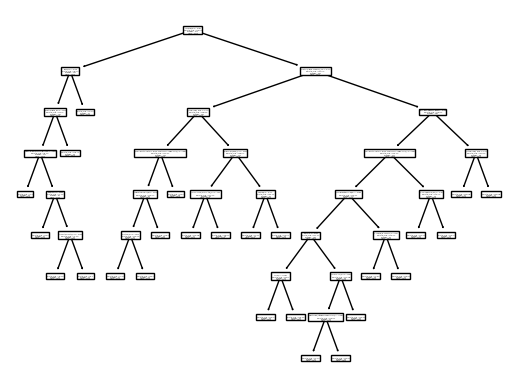

,model,data_set,mse,mae,rmse,r2
0,"DecisionTreeRegressor(criterion='absolute_error', max_depth=15,\n min_samples_leaf=20, min_samples_split=15,\n random_state=54, splitter='random')",training,31945.046,117.893,178.732,0.187
1,"DecisionTreeRegressor(criterion='absolute_error', max_depth=15,\n min_samples_leaf=20, min_samples_split=15,\n random_state=54, splitter='random')",test,41085.078,139.340,202.695,0.060


In [96]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=15, min_samples_leaf=20, min_samples_split=15, splitter='random', random_state=54)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

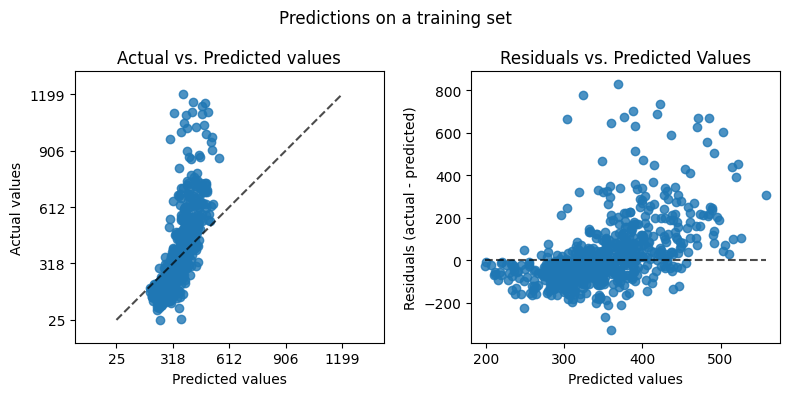

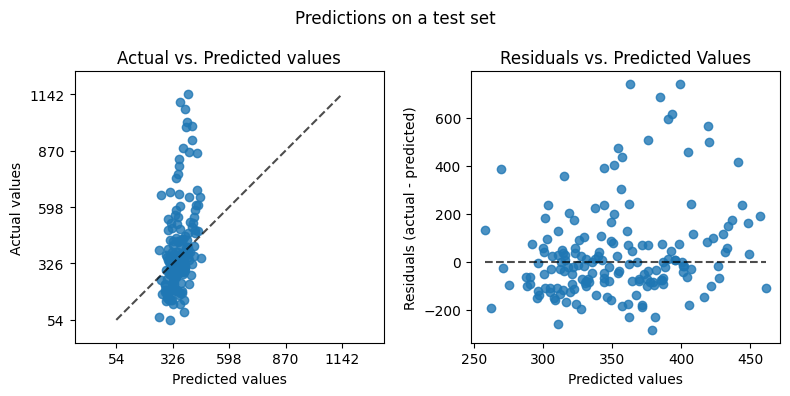

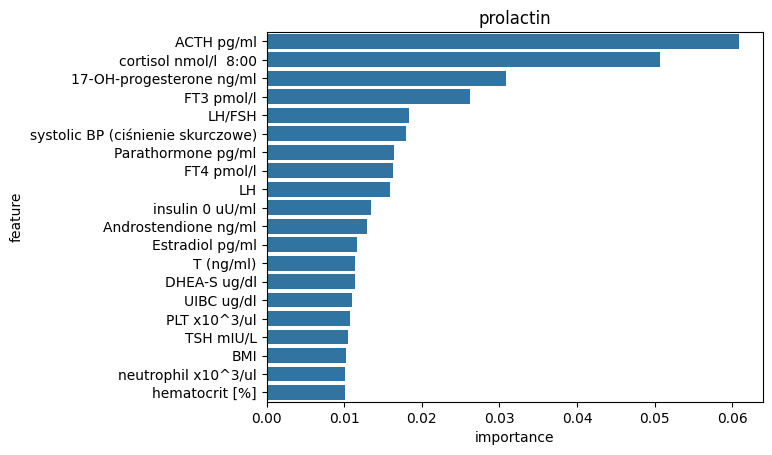

,model,data_set,mse,mae,rmse,r2
0,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=10, min_samples_split=15,\n random_state=77)",training,25703.985,105.254,160.325,0.346
1,"RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n min_samples_leaf=10, min_samples_split=15,\n random_state=77)",test,38908.839,133.388,197.253,0.110


In [97]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, max_features='sqrt', min_samples_leaf=10, min_samples_split=15, criterion='absolute_error', random_state=77)
vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, PROLACTIN, X_train_prolactin, y_train_prolactin, X_test_prolactin, y_test_prolactin, continuous_preprocessor, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df